# Inspecting Local Search Regions in the 360 Tracking Framework

This notebook is designed to inspect the local search regions extracted by a 360-degree tracking framework `OmniImage` for each frame in a video sequence. The goal is to visualize and analyze the regions that are passed to the tracking model, which is essential for understanding how the tracker operates in a 360-degree environment.

## Steps:

### 1. Initial Setup:
The notebook begins by importing necessary libraries such as `matplotlib`, `numpy`, `cv2`, and custom libraries from the `360VOT` project, which are essential for handling 360-degree video processing, bounding field-of-view (BFoV) calculations, and other utilities.

### 2. Function Definitions:
- **`get_frame_and_bfov(seq_num, frame_num)`**: This function retrieves the frame and the associated bounding field-of-view (BFoV) parameters from precomputed results stored in text files. The BFoV parameters include the center longitude and latitude (`clon`, `clat`), horizontal and vertical field-of-view (`fov_h`, `fov_v`), and rotation.
- **`get_frame_and_bbox(seq_num, frame_num)`**: Similar to the previous function, but it retrieves the bounding box coordinates for the object in the frame rather than the BFoV.

### 3. Visualization and Analysis:
The notebook includes code to visualize the global BFoV for a frame and then extract the corresponding local search region that the tracker would focus on for the next frame. This involves using functions like `omni.plot_bfov` to plot the BFoV on the frame and `omni.crop_bfov` to extract the local search region.

### 4. Execution and Display:
The code runs through sequences of frames, printing and plotting the global BFoV and the local search regions extracted for each frame. This allows for an in-depth inspection of how the tracker adjusts its search region based on the changing BFoV across frames.

### 5. Video Creation:
The notebook also includes a section to create a video from a sequence of images, which might be used to visualize the tracking process over time. This is achieved using OpenCV, where images from a specified folder are read and compiled into a video file.


In [32]:
import os
os.chdir('../360VOT')

from lib.omni import *
from lib.utils import *
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
from typing import Tuple, List
import numpy as np
import cv2

In [33]:
def get_frame_and_bfov(seq_num, frame_num):
    # predictions file
    file_path = f'/Users/aarsh/Desktop/CGVI/Thesis/benchmark/360VOT-bfov-results/AiATrack-360-bfov/{seq_num}.txt'
    frame = cv2.imread(f'/Users/aarsh/Desktop/CGVI/Thesis/Data/Test_3840x1920/{seq_num}/image/{frame_num}.jpg')
    # Read the text file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize a dictionary to hold the frame data
    frames_dict = {}

    # Parse each line in the text file
    for frame_number, line in enumerate(lines, start=0):
        values = line.split()
        clon, clat, fov_h, fov_v, rotation = map(float, values)
        
        # Organize the data frame number-wise
        frame_data = {
            "clon": clon,
            "clat": clat,
            "fov_h": fov_h,
            "fov_v": fov_v,
            "rotation": rotation
        }
        
        frames_dict[frame_number] = frame_data
    
    return frames_dict, frame

def get_frame_and_bbox(seq_num, frame_num):
    # predictions file
    file_path = f'/Users/aarsh/Desktop/CGVI/Thesis/benchmark/360VOT-bbox-results/AiATrack-360/{seq_num}.txt'
    frame = cv2.imread(f'/Users/aarsh/Desktop/CGVI/Thesis/Data/Test_3840x1920/{seq_num}/image/{frame_num}.jpg')
    # Read the text file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize a dictionary to hold the frame data
    frames_dict = {}

    # Parse each line in the text file
    for frame_number, line in enumerate(lines, start=0):
        values = line.split()
        x, y, w, h= map(float, values)
        
        # Organize the data frame number-wise
        frame_data = {
            "x": x,
            "y": y,
            "w": w,
            "h": h,
        }
        
        frames_dict[frame_number] = frame_data
    
    return frames_dict, frame

## Initialize `OmniImage`

In [34]:
omni = OmniImage(img_w=3840,img_h=1920)

In [60]:
curr_seq_num = 615
next_seq_num = 615

## Get BFoV information first, cause this is where the process starts

In [61]:
frames_dict, cur_frame = get_frame_and_bfov('0018', '000'  + str(curr_seq_num))
global_bfov_cur = Bfov(frames_dict[curr_seq_num]['clon'], frames_dict[curr_seq_num]['clat'], frames_dict[curr_seq_num]['fov_h'], frames_dict[curr_seq_num]['fov_v'])

In [62]:
frames_dict[curr_seq_num]

{'clon': -76.56939411163322,
 'clat': 29.540592977565357,
 'fov_h': 214.45048433583926,
 'fov_v': 103.90681754985545,
 'rotation': 0.0}

# Plot the BfoV for this frame

Projection type = 2: extendedBFoV (sampling on the sphere) because FOVs are (214.45048433583926, 103.90681754985545) > 90 degrees


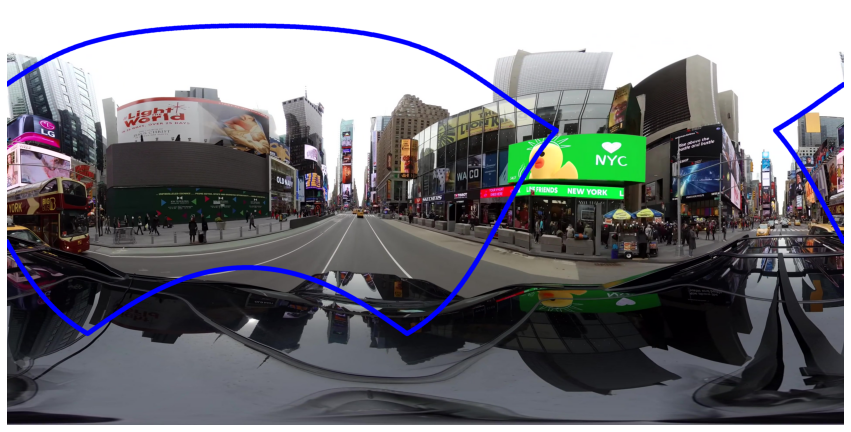

In [63]:
curr_frame_copy = cur_frame.copy()
plt.figure(figsize=(15, 15))
plt.imshow(omni.plot_bfov(curr_frame_copy, global_bfov_cur, size = 20)[:, :, ::-1])
plt.axis('off')
plt.show()

## Get `local_search_region_next` in the spherical coordinate system, and get `ref_u`, `ref_v` for later usage (coming to this soon).

- This computation inherently handles the `projection` type logic based on `fov_h` and `fov_v` params of the `global_bfov_cur`

In [64]:
local_search_region_next, ref_u, ref_v = omni.crop_bfov(cur_frame, global_bfov_cur, num_sample_h=320, num_sample_v=320)

Projection type = 2: extendedBFoV (sampling on the sphere) because FOVs are (214.45048433583926, 103.90681754985545) > 90 degrees


## View next frame local search region

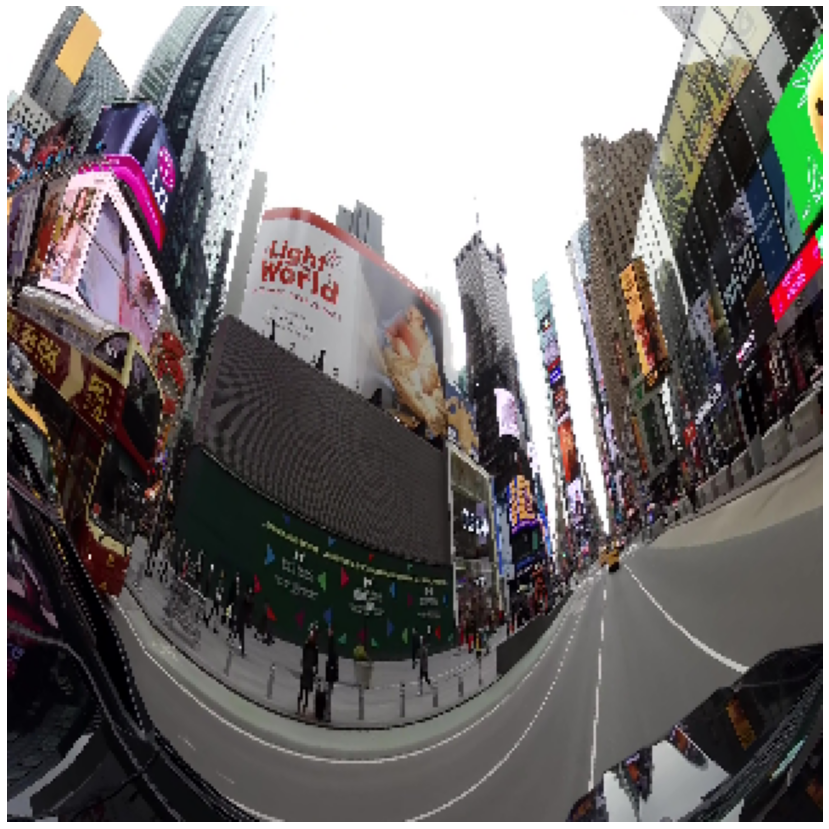

In [65]:
plt.figure(figsize=(15, 15))
plt.imshow(local_search_region_next[:, :, ::-1])
plt.axis('off')
plt.show()

## Tracker makes predictions on `local_search_region_cur` and outputs a `local_bbox`

1. this `local_bbox` is then converted to a `global_bfov_next` with `omni.localBbox2Bfov(local_bbox, ref_u, ref_v)`, but since we only have `global` values i'll use `bbox2bfov` instead.

In [9]:
frames_dict_bbox, next_frame = get_frame_and_bbox('0018', '000' + str(next_seq_num)) # one step ahead because search region is based around the previous prediction
bbox = [int(frames_dict_bbox[next_seq_num]['x']), int(frames_dict_bbox[next_seq_num]['y']), int(frames_dict_bbox[next_seq_num]['w']), int(frames_dict_bbox[next_seq_num]['h'])]
global_bbox = x1y1wh2bbox(bbox)

## Plot this `global_bbox`

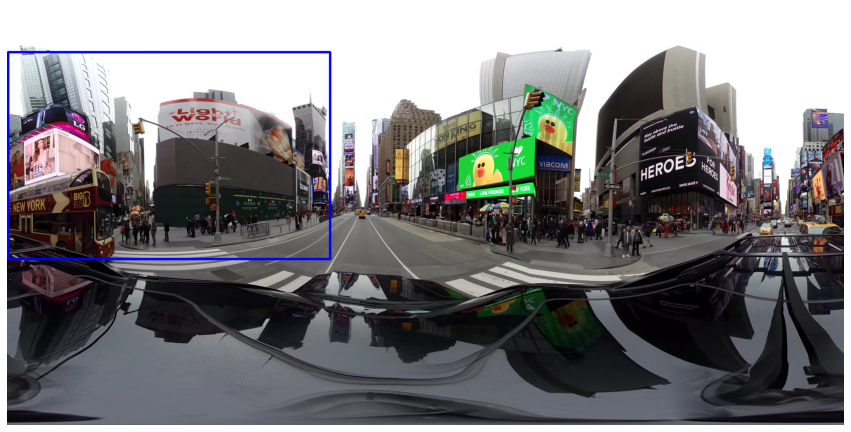

In [10]:
next_frame_copy = next_frame.copy()
plt.figure(figsize=(15, 15))
plt.imshow(omni.plot_bbox(next_frame_copy, global_bbox)[:, :, ::-1])
plt.axis('off')
plt.show()

## Convert this `global_bbox` to a `global_bfov` to get `local_search_region_next_frame`

In [11]:
global_bfov_next, _, _, _, _ = omni.bbox2Bfov(global_bbox)

## Get `local_search_region_next_frame` in the spherical coordinate system, and update `ref_u` and `ref_v` to be `new_ref_u`, and `new_ref_v` for the next round

- This computation inherently handles the `projection` type logic based on `fov_h` and `fov_v` params of the `global_Bfov_next`

In [12]:
local_search_region_next_next_frame, new_ref_u, new_ref_v = omni.crop_bfov(next_frame, global_bfov_next)

Projection type = 2: extendedBFoV (sampling on the sphere) because FOVs are (159.10819597639286, 97.11103833445465) > 90 degrees


## View `local_search_region_next_next_frame`

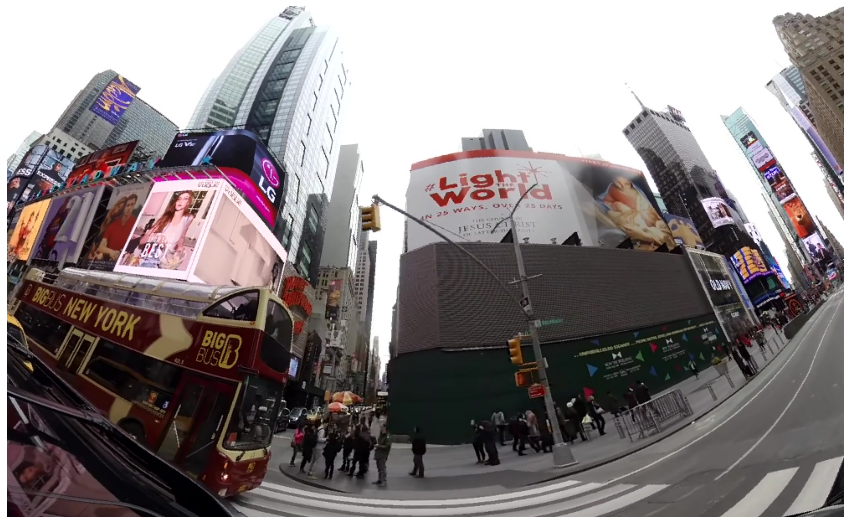

In [13]:
plt.figure(figsize=(15, 15))
plt.imshow(local_search_region_next_next_frame[:, :, ::-1])
plt.axis('off')
plt.show()

## REPEATING

Prediction at this frame



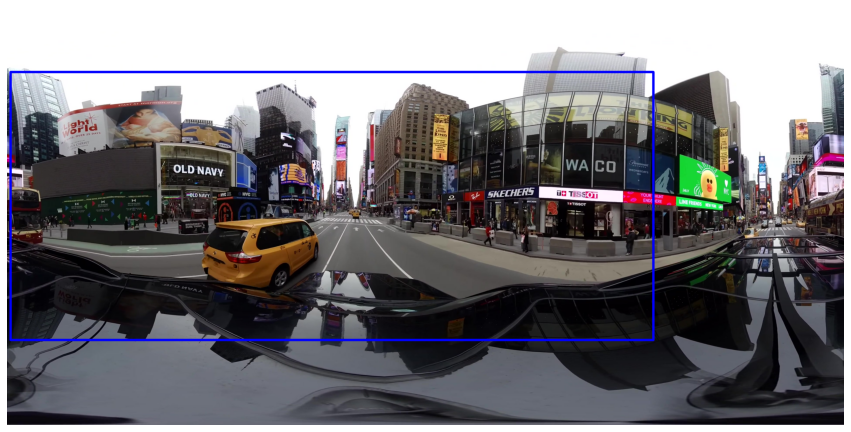

Global BFoV at this frame 

Projection type = 2: extendedBFoV (sampling on the sphere) because FOVs are (283.17681371142925, 122.11154514338507) > 90 degrees


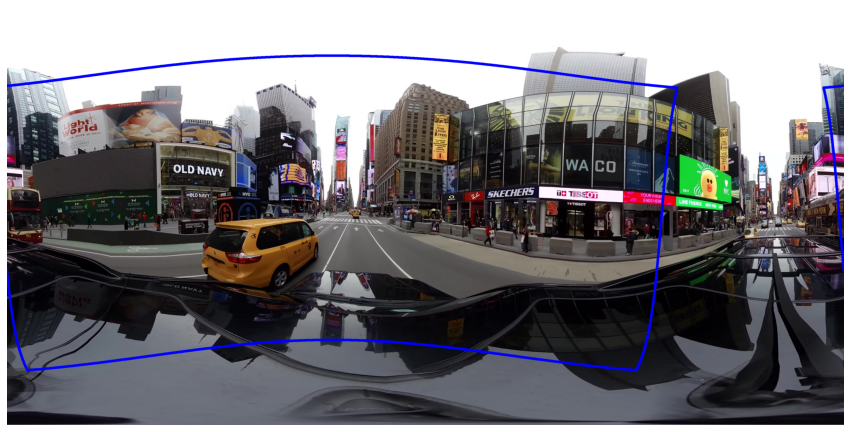

Projection type = 2: extendedBFoV (sampling on the sphere) because FOVs are (283.17681371142925, 122.11154514338507) > 90 degrees
Local Search Region for the next frame 



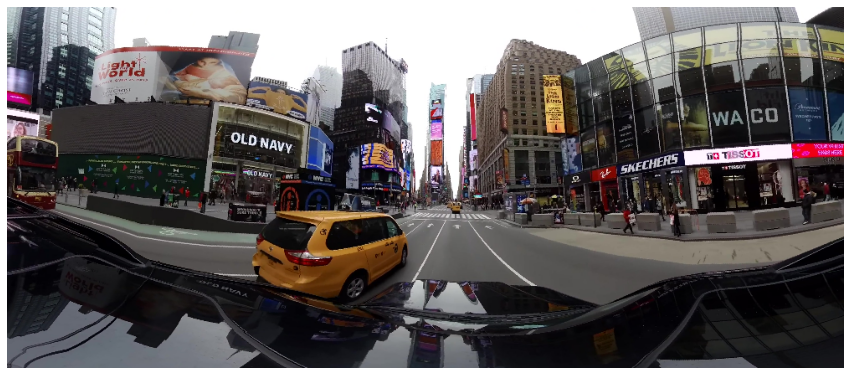

In [14]:
next_next_seq_num = 640
frames_dict_bbox, next_next_frame = get_frame_and_bbox('0018', '000' + str(next_next_seq_num)) # one step ahead because search region is based around the previous prediction
bbox_next = [int(frames_dict_bbox[next_next_seq_num]['x']), int(frames_dict_bbox[next_next_seq_num]['y']), int(frames_dict_bbox[next_next_seq_num]['w']), int(frames_dict_bbox[next_next_seq_num]['h'])]
global_bbox_next_next = x1y1wh2bbox(bbox_next)

print("Prediction at this frame\n")
next_next_frame_copy = next_next_frame.copy()
plt.figure(figsize=(15, 15))
plt.imshow(omni.plot_bbox(next_next_frame_copy, global_bbox_next_next)[:, :, ::-1])
plt.axis('off')
plt.show()


# convert to BFoV -> Local Search Region next next next 
global_bfov_next_next, _, _, _, _ = omni.bbox2Bfov(global_bbox_next_next)

next_next_bfov_frame_copy = next_next_frame.copy()
print("Global BFoV at this frame \n")
plt.figure(figsize=(15, 15))
plt.imshow(omni.plot_bfov(next_next_bfov_frame_copy, global_bfov_next_next)[:, :, ::-1])
plt.axis('off')
plt.show()


local_search_region_next_next_next_frame, new_ref_u, new_ref_v = omni.crop_bfov(next_next_frame, global_bfov_next_next)

print("Local Search Region for the next frame \n")
plt.figure(figsize=(15, 15))
plt.imshow(local_search_region_next_next_next_frame[:, :, ::-1])
plt.axis('off')
plt.show()

In [15]:
print(next_next_seq_num)

640
